# PUBG Dataset
This is an analysis including causal inference for the PUBG dataset found [here](https://www.kaggle.com/datasets/razamh/pubg-dataset/).
The dataset contains  1,111,742 samples with the following columns:
DBNOs- Number of enemy players knocked.
* assists- Number of enemy players this player damaged that were killed by teammates.
* boosts - Number of boost items used.
* damageDealt- Total damage dealt. Note: Self inflicted damage is subtracted.
* headshotKills- Number of enemy players killed with headshots.
* heals- Number of healing items used.
* Id- Player’s Id
killPlace- Ranking in match of number of enemy players killed.
* killPoints- Kills-based external ranking of players. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
* killStreaks- Max number of enemy players killed in a short amount of time.
* kills - Number of enemy players killed.
* longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
* matchDuration - Duration of match in seconds.
* matchId - ID to identify matches. There are no matches that are in both the training and testing set.
* matchType - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
* rankPoints - Elo-like ranking of players. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes the place of “None”.
* revives - Number of times this player revived teammates.
* rideDistance - Total distance traveled in vehicles measured in meters.
* roadKills - Number of kills while in a vehicle.
* swimDistance - Total distance traveled by swimming measured in meters.
* teamKills - Number of times this player killed a teammate.
* vehicleDestroys - Number of vehicles destroyed.
* walkDistance - Total distance traveled on foot measured in meters.
* weaponsAcquired - Number of weapons picked up.
* winPoints - Win-based external ranking of players. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
* groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
* numGroups - Number of groups we have data for in the match.
* maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
* winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the - - match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

In [2]:
df = pd.read_csv("./data/pubg.csv")
df.drop(columns=["Unnamed: 0", "Id", "groupId", "matchId"], inplace=True)
df.head()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,0,25.93,0,0,0,84,1437,0,0,...,0,0.0,0,0.0,0,0,151.30,1,1525,0.0667
1,0,0,36.71,0,0,0,57,1225,0,0,...,0,0.0,0,0.0,0,0,1918.00,7,1516,0.5862
2,0,1,47.73,0,0,0,50,0,0,0,...,0,4088.0,0,0.0,0,0,820.00,7,0,0.8105
3,0,0,0.00,0,0,0,56,1286,0,0,...,1,0.0,0,0.0,0,0,38.81,0,1515,0.5556
4,0,2,100.00,0,0,3,31,0,1,1,...,0,918.4,0,0.0,0,0,1721.00,5,0,0.6429


# EDA

In [3]:
df.isnull().sum()

assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

In [4]:
df[df['winPlacePerc'].isnull()]

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
184895,0,0,0.0,0,0,0,1,0,0,0,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [5]:
df = df.dropna()
df.dtypes

assists              int64
boosts               int64
damageDealt        float64
DBNOs                int64
headshotKills        int64
heals                int64
killPlace            int64
killPoints           int64
kills                int64
killStreaks          int64
longestKill        float64
matchDuration        int64
matchType           object
maxPlace             int64
numGroups            int64
rankPoints           int64
revives              int64
rideDistance       float64
roadKills            int64
swimDistance       float64
teamKills            int64
vehicleDestroys      int64
walkDistance       float64
weaponsAcquired      int64
winPoints            int64
winPlacePerc       float64
dtype: object

In [6]:
df["matchType"]

0          squad-fpp
1          squad-fpp
2           solo-fpp
3          squad-fpp
4               solo
             ...    
1111737    squad-fpp
1111738     solo-fpp
1111739          duo
1111740    squad-fpp
1111741    squad-fpp
Name: matchType, Length: 1111741, dtype: object

In [7]:
df["matchType"] = df["matchType"].astype('category').cat.codes
df["matchType"]

0          15
1          15
2          13
3          15
4          12
           ..
1111737    15
1111738    13
1111739     2
1111740    15
1111741    15
Name: matchType, Length: 1111741, dtype: int8

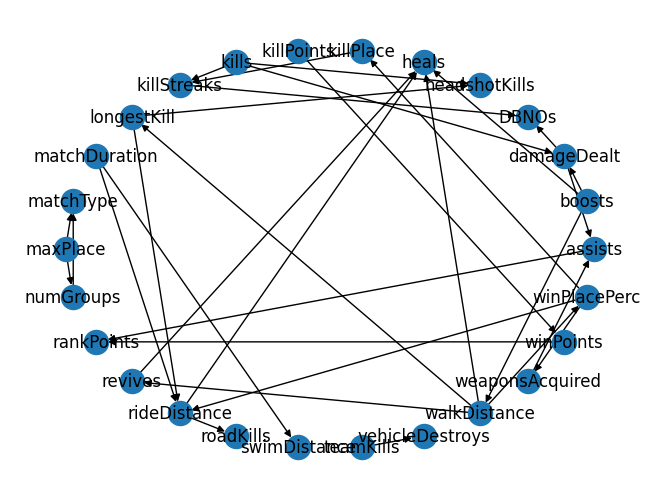

In [8]:
import why

df_sample = df.sample(1000)
indep_test = why.CausalDiscovery.PearsonsCorrelation(0.05)
pc = why.CausalDiscovery.CausalDiscoveryPC(df_sample, indep_test)

graph = pc.get_networkx_graph(draw=False)
graph = why.CausalDiscovery.NonGaussianOrientation().orient_edges(graph, df.sample(20000))
nx.draw_circular(graph, with_labels=True)

In [17]:
from sklearn.linear_model import LinearRegression

def estimate_effect(treatment, outcome):
    adjustor = why.BackdoorAdjustment(graph)
    adjustment_sets = adjustor.get_all_backdoor_adjustment_set(treatment, outcome, 1)
    if len(adjustment_sets) == 0:
        print("No causal chain found between {} and {}".format(treatment, outcome))
    minimal_adjustment_set = list(adjustment_sets[0])

    df_estimation = df_sample.copy()
    df_estimation[treatment] = df_sample[treatment] > df_sample[treatment].mean()
    estimator = why.Estimation.GCOMEstimator(df_estimation, LinearRegression())
    gcom_linear_ate_max = estimator.estimate(treatment, outcome, minimal_adjustment_set)
    print(f"GCOM Linear ATE between {treatment} and {outcome}: {gcom_linear_ate_max:.4f}")

estimate_effect("kills", "winPlacePerc")
estimate_effect("damageDealt", "assists")


Warning, GCOM: No adjustment set provided, returning ate = E[Y|T=1]-E[Y|T=0]
GCOM Linear ATE between kills and winPlacePerc: 0.2561
GCOM Linear ATE between damageDealt and assists: 0.2272
